# Question 1

## (i)

-2.6638764156671604
-2.6638764156671604
-2.6638764156671604
-2.6638764156671604
-2.6638764156671604
-2.6638764156671604
-2.6638764156671604
-2.6638764156671604
-2.6638764156671604
-2.6638764156671604
-2.6438764156671604


Text(100, 0, 'H')

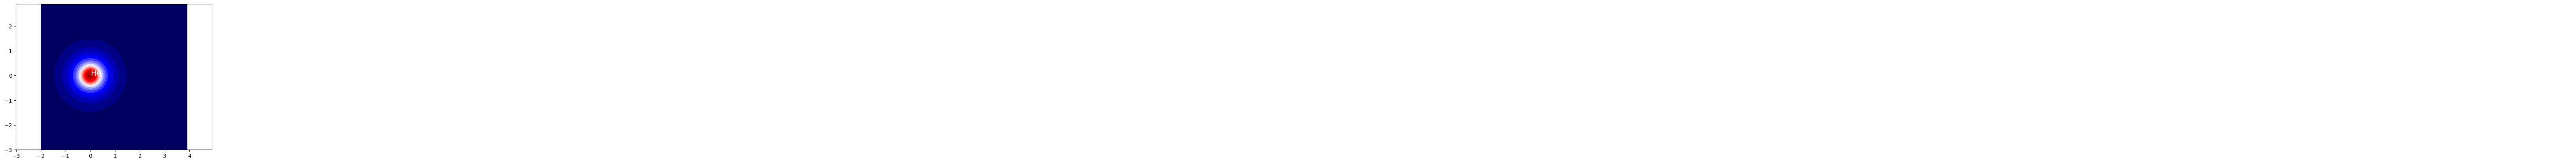

In [18]:
# import packages for basic math, plotting, linear algebra, etc.
from numpy import *
from numpy.linalg import *
from numpy.random import *
from matplotlib.pyplot import *
from scipy.special import binom, erf, erfc

def eigSinvH(S,H): 
    SinvH = inv(S) @ H
    E, U = eig(SinvH)

    order = argsort(real(E))
    c = zeros((K, K))
    for i in range(K):
        c[:, i] = real(U[:, order[i]])
        c[:, i] = c[:, i] / sqrt(c[:, i] @ S @ c[:, i])
    E = sort(real(E))
    return E, c

def F0(x): # Boys Function Approximation
    if (x < 1e-8):
        return 1 - x/3
    else:
        return 0.5*sqrt(pi)*erf(sqrt(x))/sqrt(x)

def compute_overlap(alpha, beta, RA, RB):
    absum = alpha + beta
    abfac = alpha * beta / absum
    dRAB = RA - RB
    dRAB2 = dRAB @ dRAB
    return (pi/absum)**(3/2) * exp(-abfac * dRAB2)

def compute_kinetic_energy(alpha, beta, RA, RB): # kinetic energy (one body operator term)
    absum = alpha + beta
    abfac = alpha * beta / absum
    dRAB = RA - RB
    dRAB2 = dRAB @ dRAB
    return (pi/absum)**(3/2) * exp(-abfac * dRAB2) * \
            abfac * (3 - 2*abfac * dRAB2)

def compute_elec_nuc_energy(alpha, beta, RA, RB, RC): # electron nuclear attraction (one body operator term)
    absum = alpha + beta
    abfac = alpha * beta / absum
    dRAB = RA - RB
    dRAB2 = dRAB @ dRAB
    RP = (alpha*RA + beta*RB)/absum
    dRPC = RP - RC
    dRPC2 = dRPC @ dRPC
    return -(2*pi/absum)*exp(-abfac * dRAB2) * \
            F0(absum * dRPC2)

def compute_elec_elec_energy(alpha,beta,gamma,delta,RA,RB,RC,RD): # J and K term (two body operator terms)
    absum = alpha + beta
    abfac = alpha * beta / absum
    dRAB = RA - RB
    dRAB2 = dRAB @ dRAB
    RP = (alpha*RA + beta*RB)/absum

    gdsum = gamma + delta
    gdfac = gamma * delta / gdsum
    dRCD = RC - RD
    dRCD2 = dRCD @ dRCD
    RQ = (gamma*RC + delta*RD) / gdsum
    dRPQ = RP - RQ
    dRPQ2 = dRPQ @ dRPQ

    abgdsum = absum + gdsum
    abgdfac = absum * gdsum / abgdsum

    return 2 * pi**(5/2) * (absum * gdsum * sqrt(abgdsum))**(-1) * \
            exp(-abfac*dRAB2 - gdfac*dRCD2) * \
            F0(abgdfac * dRPQ2)

N = 2
N_nuclei = 2
z_nuclei = array([2, 1])
K = 2 # number of basis functions
L = 3 # number of Gaussians used to build each basis function

widths = zeros((L,K))
contraction_coeffs = zeros((L,K)) # we called these d
centers = zeros((L,K,3))

# contraction coeffs for gaussian basis sets 
alpha1s_STO3G = array([0.109818, 0.405771, 2.22766])
d1s_STO3G = array([0.316894, 0.381531, 0.109991])

# 1s on He
zeta_He = 2.0925 
widths[:,0] = alpha1s_STO3G * zeta_He**2
contraction_coeffs[:,0] = d1s_STO3G * widths[:,0]**(3/4)

# 1s on H
zeta_H = 1.24
widths[:,1] = alpha1s_STO3G * zeta_H**2
contraction_coeffs[:,1] = d1s_STO3G * widths[:,1]**(3/4)

R_nuclei = zeros((N_nuclei,3))
# R = 1.4632
R = 100 # Nuclear Seperation distance
R_nuclei[1,0] = R

centers[0,1,0] = R
centers[1,1,0] = R
centers[2,1,0] = R

S = zeros((K,K))
T = zeros((K,K)) # kinetic energy matrix elements
U1 = zeros((K,K)) # E_nuc matrix elements
U2 = zeros((K,K,K,K)) # two body operator matrix elements

# compute matrix elements
for mu in range(K):
    for A in range(L):
        alpha = widths[A,mu]
        dAmu = contraction_coeffs[A,mu]
        RA = centers[A,mu,:]

        for nu in range(K):
            for B in range(L):
                beta = widths[B,nu]
                dBnu = contraction_coeffs[B,nu]
                RB = centers[B,nu,:]

                S[mu,nu] += dAmu * dBnu * compute_overlap(alpha, beta, RA, RB) # compute one body operator terms

                T[mu,nu] += dAmu * dBnu * compute_kinetic_energy(alpha, beta, RA, RB)

                for nucleus in range(N_nuclei): # 
                    U1[mu,nu] += dAmu * dBnu * z_nuclei[nucleus]  * \
                        compute_elec_nuc_energy(alpha, beta, RA, RB, R_nuclei[nucleus])

                for sigma in range(K):
                    for C in range(L):
                        gamma = widths[C,sigma]
                        dCsigma = contraction_coeffs[C,sigma]
                        RC = centers[C,sigma,:]

                        for lam in range(K):
                            for D in range(L):
                                delta = widths[D,lam]
                                dDlam = contraction_coeffs[D,lam]
                                RD = centers[D,lam,:]

                                # compute two body operator terms
                                U2[mu,nu,sigma,lam] += dAmu * dBnu * dCsigma * dDlam * \
                        compute_elec_elec_energy(alpha, beta, gamma, delta, RA, RB, RC, RD)

h = T + U1
E, c = eigSinvH(S,h)

Nover2 = int(N/2)

n_iterations = 10
for iterate in range(n_iterations): # compute density matrix
    P = zeros((K,K))
    for mu in range(K):
        for nu in range(K):
            for j in range(Nover2):
                P[mu,nu] += 2 * c[mu,j] * c[nu,j]

    F = copy(h) # construct Fock Matrix
    for mu in range(K):
        for nu in range(K):
            for lam in range(K):
                for sigma in range(K):
                    F[mu,nu] += P[lam,sigma] * \
                                ( U2[mu,nu,lam,sigma] - 0.5*U2[mu,sigma,lam,nu] )

    E, c = eigSinvH(S,F)

    E_elec = sum(E[0:Nover2]) + 0.5 * trace(P @ h) # solve the SCF equations
    print(E_elec)

# energy of nuclear repulsion
E_nuc = 0
for nucleus1 in range(N_nuclei):
    for nucleus2 in range(nucleus1+1,N_nuclei):
        dR = R_nuclei[nucleus1,:] - R_nuclei[nucleus2,:]
        dR2 = dR @ dR
        E_nuc += z_nuclei[nucleus1] * z_nuclei[nucleus2] / sqrt(dR2)

E_total = E_elec + E_nuc
print(E_total)

xvals = arange(-2,4,0.1) # define grid
yvals = arange(-3, 3, 0.1)
nvals = size(xvals)
state = 0
psi = zeros((nvals,nvals))
for i in range(nvals):
    x = xvals[i]
    for j in range(nvals):
        y = yvals[j]

        for mu in range(K):
            for A in range(L):
                alpha = widths[A,mu]
                dAmu = contraction_coeffs[A,mu]
                RA = centers[A,mu,:]
                xA = RA[0]
                yA = RA[1]
                phiA = exp(-alpha* ( (x-xA)**2 + (y-yA)**2 ) )

                psi[j,i] += c[mu,state] * dAmu * phiA # sum up gaussian wavefunctions

clf()
contourf(xvals, yvals, psi, levels=20, cmap=cm.seismic)
axis('equal')
text(0,0,'He',color='White',fontsize=14)
text(R,0,'H',color='White',fontsize=14)

## (ii)

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
from tqdm import tqdm

In [13]:
Rs = np.linspace(0.5, 5, 100)
Es = []

N = 2
N_nuclei = 2
z_nuclei = array([2, 1])
K = 2 # number of basis functions
L = 3 # number of Gaussians used to build each basis function

widths = zeros((L,K))
contraction_coeffs = zeros((L,K)) # we called these d
centers = zeros((L,K,3))

# contraction coeffs for gaussian basis sets 
alpha1s_STO3G = array([0.109818, 0.405771, 2.22766])
d1s_STO3G = array([0.316894, 0.381531, 0.109991])

# 1s on He
zeta_He = 2.0925 
widths[:,0] = alpha1s_STO3G * zeta_He**2
contraction_coeffs[:,0] = d1s_STO3G * widths[:,0]**(3/4)

# 1s on H
zeta_H = 1.24
widths[:,1] = alpha1s_STO3G * zeta_H**2
contraction_coeffs[:,1] = d1s_STO3G * widths[:,1]**(3/4)

R_nuclei = zeros((N_nuclei,3))
# R = 1.4632

for R in tqdm(Rs):
    R_nuclei[1,0] = R
    
    centers[0,1,0] = R
    centers[1,1,0] = R
    centers[2,1,0] = R
    
    S = zeros((K,K))
    T = zeros((K,K)) # kinetic energy matrix elements
    U1 = zeros((K,K)) # E_nuc matrix elements
    U2 = zeros((K,K,K,K)) # two body operator matrix elements
    
    # compute matrix elements
    for mu in range(K):
        for A in range(L):
            alpha = widths[A,mu]
            dAmu = contraction_coeffs[A,mu]
            RA = centers[A,mu,:]
    
            for nu in range(K):
                for B in range(L):
                    beta = widths[B,nu]
                    dBnu = contraction_coeffs[B,nu]
                    RB = centers[B,nu,:]
    
                    S[mu,nu] += dAmu * dBnu * compute_overlap(alpha, beta, RA, RB) # compute one body operator terms
    
                    T[mu,nu] += dAmu * dBnu * compute_kinetic_energy(alpha, beta, RA, RB)
    
                    for nucleus in range(N_nuclei): # 
                        U1[mu,nu] += dAmu * dBnu * z_nuclei[nucleus]  * \
                            compute_elec_nuc_energy(alpha, beta, RA, RB, R_nuclei[nucleus])
    
                    for sigma in range(K):
                        for C in range(L):
                            gamma = widths[C,sigma]
                            dCsigma = contraction_coeffs[C,sigma]
                            RC = centers[C,sigma,:]
    
                            for lam in range(K):
                                for D in range(L):
                                    delta = widths[D,lam]
                                    dDlam = contraction_coeffs[D,lam]
                                    RD = centers[D,lam,:]
    
                                    # compute two body operator terms
                                    U2[mu,nu,sigma,lam] += dAmu * dBnu * dCsigma * dDlam * \
                            compute_elec_elec_energy(alpha, beta, gamma, delta, RA, RB, RC, RD)
    
    h = T + U1
    E, c = eigSinvH(S,h)
    
    Nover2 = int(N/2)
    
    n_iterations = 10
    for iterate in range(n_iterations): # compute density matrix
        P = zeros((K,K))
        for mu in range(K):
            for nu in range(K):
                for j in range(Nover2):
                    P[mu,nu] += 2 * c[mu,j] * c[nu,j]
    
        F = copy(h) # construct Fock Matrix
        for mu in range(K):
            for nu in range(K):
                for lam in range(K):
                    for sigma in range(K):
                        F[mu,nu] += P[lam,sigma] * \
                                    ( U2[mu,nu,lam,sigma] - 0.5*U2[mu,sigma,lam,nu] )
    
        E, c = eigSinvH(S,F)
    
        E_elec = sum(E[0:Nover2]) + 0.5 * trace(P @ h) # solve the SCF equations
        # print(E_elec)
    
    # energy of nuclear repulsion
    E_nuc = 0
    for nucleus1 in range(N_nuclei):
        for nucleus2 in range(nucleus1+1,N_nuclei):
            dR = R_nuclei[nucleus1,:] - R_nuclei[nucleus2,:]
            dR2 = dR @ dR
            E_nuc += z_nuclei[nucleus1] * z_nuclei[nucleus2] / sqrt(dR2)
    
    E_total = E_elec + E_nuc
    Es.append(E_total)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 69.54it/s]


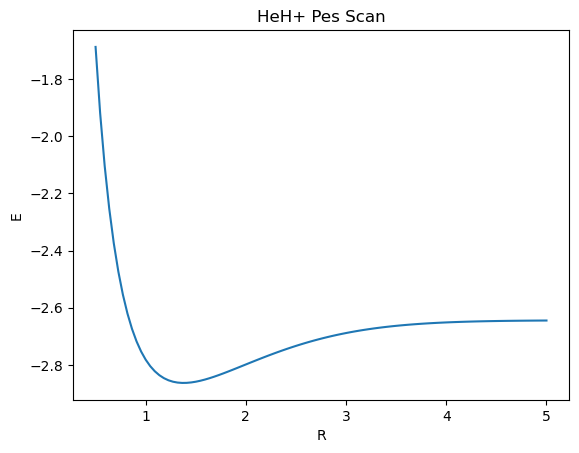

In [14]:
# plt.rcParams['text.usetex'] = True

fig, ax = plt.subplots()
ax.plot(Rs, Es)
ax.set_title('HeH+ Pes Scan')
ax.set_xlabel('R')
ax.set_ylabel('E')
plt.savefig('Visualizations/1_ii.png')

## (iii)

In [15]:
E_well = min(Es)
E_infty = Es[-1]
E_diss = E_infty - E_well
print(f'E_diss (Hartree): {E_diss}')
print(f'E_diss (kcal/mol): {E_diss * 630}')

E_diss (Hartree): 0.21810524653454522
E_diss (kcal/mol): 137.40630531676348


HF overbinds in comparison to the true dissociation energy approximately by a factor of 3

## (iv)

In [16]:
N = 2
N_nuclei = 2
z_nuclei = array([2, 1])
K = 2 # number of basis functions
L = 3 # number of Gaussians used to build each basis function

widths = zeros((L,K))
contraction_coeffs = zeros((L,K)) # we called these d
centers = zeros((L,K,3))

# contraction coeffs for gaussian basis sets 
alpha1s_STO3G = array([0.109818, 0.405771, 2.22766])
d1s_STO3G = array([0.316894, 0.381531, 0.109991])

# 1s on He
zeta_He = 2.0925 
widths[:,0] = alpha1s_STO3G * zeta_He**2
contraction_coeffs[:,0] = d1s_STO3G * widths[:,0]**(3/4)

# 1s on H
zeta_H = 1.24
widths[:,1] = alpha1s_STO3G * zeta_H**2
contraction_coeffs[:,1] = d1s_STO3G * widths[:,1]**(3/4)

R_nuclei = zeros((N_nuclei,3))
R = 1000
R_nuclei[1,0] = R

centers[0,1,0] = R
centers[1,1,0] = R
centers[2,1,0] = R

S = zeros((K,K))
T = zeros((K,K)) # kinetic energy matrix elements
U1 = zeros((K,K)) # E_nuc matrix elements
U2 = zeros((K,K,K,K)) # two body operator matrix elements

# compute matrix elements
for mu in range(K):
    for A in range(L):
        alpha = widths[A,mu]
        dAmu = contraction_coeffs[A,mu]
        RA = centers[A,mu,:]

        for nu in range(K):
            for B in range(L):
                beta = widths[B,nu]
                dBnu = contraction_coeffs[B,nu]
                RB = centers[B,nu,:]

                S[mu,nu] += dAmu * dBnu * compute_overlap(alpha, beta, RA, RB) # compute one body operator terms

                T[mu,nu] += dAmu * dBnu * compute_kinetic_energy(alpha, beta, RA, RB)

                for nucleus in range(N_nuclei): # 
                    U1[mu,nu] += dAmu * dBnu * z_nuclei[nucleus]  * \
                        compute_elec_nuc_energy(alpha, beta, RA, RB, R_nuclei[nucleus])

                for sigma in range(K):
                    for C in range(L):
                        gamma = widths[C,sigma]
                        dCsigma = contraction_coeffs[C,sigma]
                        RC = centers[C,sigma,:]

                        for lam in range(K):
                            for D in range(L):
                                delta = widths[D,lam]
                                dDlam = contraction_coeffs[D,lam]
                                RD = centers[D,lam,:]

                                # compute two body operator terms
                                U2[mu,nu,sigma,lam] += dAmu * dBnu * dCsigma * dDlam * \
                        compute_elec_elec_energy(alpha, beta, gamma, delta, RA, RB, RC, RD)

h = T + U1
E, c = eigSinvH(S,h)

Nover2 = int(N/2)

n_iterations = 10
for iterate in range(n_iterations): # compute density matrix
    P = zeros((K,K))
    for mu in range(K):
        for nu in range(K):
            for j in range(Nover2):
                P[mu,nu] += 2 * c[mu,j] * c[nu,j]

    F = copy(h) # construct Fock Matrix
    for mu in range(K):
        for nu in range(K):
            for lam in range(K):
                for sigma in range(K):
                    F[mu,nu] += P[lam,sigma] * \
                                ( U2[mu,nu,lam,sigma] - 0.5*U2[mu,sigma,lam,nu] )

    E, c = eigSinvH(S,F)
    
    E_elec = sum(E[0:Nover2]) + 0.5 * trace(P @ h) # solve the SCF equations
    E_elec = E[0]

# energy of nuclear repulsion
E_nuc = 0
for nucleus1 in range(N_nuclei):
    for nucleus2 in range(nucleus1+1,N_nuclei):
        dR = R_nuclei[nucleus1,:] - R_nuclei[nucleus2,:]
        dR2 = dR @ dR
        E_nuc += z_nuclei[nucleus1] * z_nuclei[nucleus2] / sqrt(dR2)

E_total = E_elec + E_nuc
E_I = (E_total) * 630
print(f'E_I (kcal/mol): {-1 * E_I}')

E_I (kcal/mol): 420.4396335088993


## (v)

The ionization energy is smaller for the HF solution compared to the experimental energy. 

## (vi)

In [25]:
N = 2
N_nuclei = 2
z_nuclei = array([2, 1])
K = 3 # number of basis functions
L = 3 # number of Gaussians used to build each basis function

widths = zeros((L,K))
contraction_coeffs = zeros((L,K)) # we called these d
centers = zeros((L,K,3))

# contraction coeffs for gaussian basis sets 
alpha1s_STO3G = array([0.109818, 0.405771, 2.22766])
d1s_STO3G = array([0.316894, 0.381531, 0.109991])

# 1s on He
zeta_He = 2.0925 
widths[:,0] = alpha1s_STO3G * zeta_He**2
contraction_coeffs[:,0] = d1s_STO3G * widths[:,0]**(3/4)

# 1s on H
zeta_H = 1.24
widths[:,1] = alpha1s_STO3G * zeta_H**2
contraction_coeffs[:,1] = d1s_STO3G * widths[:,1]**(3/4)

# Second 1s on He
zeta_He_2 = 1.6875
widths[:,2] = alpha1s_STO3G * zeta_He_2**2
contraction_coeffs[:,2] = d1s_STO3G * widths[:,2]**(3/4)

R_nuclei = zeros((N_nuclei,3))
R = 1.4632
R_nuclei[1,0] = R

centers[0,1,0] = R
centers[1,1,0] = R
centers[2,1,0] = R

S = zeros((K,K))
T = zeros((K,K))
U1 = zeros((K,K))
U2 = zeros((K,K,K,K))

# compute matrix elements
for mu in range(K):
    for A in range(L):
        alpha = widths[A,mu]
        dAmu = contraction_coeffs[A,mu]
        RA = centers[A,mu,:]

        for nu in range(K):
            for B in range(L):
                beta = widths[B,nu]
                dBnu = contraction_coeffs[B,nu]
                RB = centers[B,nu,:]

                S[mu,nu] += dAmu * dBnu * compute_overlap(alpha, beta, RA, RB)

                T[mu,nu] += dAmu * dBnu * compute_kinetic_energy(alpha, beta, RA, RB)

                for nucleus in range(N_nuclei):
                    U1[mu,nu] += dAmu * dBnu * z_nuclei[nucleus]  * \
                        compute_elec_nuc_energy(alpha, beta, RA, RB, R_nuclei[nucleus])

                for sigma in range(K):
                    for C in range(L):
                        gamma = widths[C,sigma]
                        dCsigma = contraction_coeffs[C,sigma]
                        RC = centers[C,sigma,:]

                        for lam in range(K):
                            for D in range(L):
                                delta = widths[D,lam]
                                dDlam = contraction_coeffs[D,lam]
                                RD = centers[D,lam,:]

                                U2[mu,nu,sigma,lam] += dAmu * dBnu * dCsigma * dDlam * \
                        compute_elec_elec_energy(alpha, beta, gamma, delta, RA, RB, RC, RD)

h = T + U1
E, c = eigSinvH(S,h)

Nover2 = int(N/2)

n_iterations = 10
for iterate in range(n_iterations): # compute density matrix
    P = zeros((K,K))
    for mu in range(K):
        for nu in range(K):
            for j in range(Nover2):
                P[mu,nu] += 2 * c[mu,j] * c[nu,j]

    F = copy(h) # construct Fock Matrix
    for mu in range(K):
        for nu in range(K):
            for lam in range(K):
                for sigma in range(K):
                    F[mu,nu] += P[lam,sigma] * \
                                ( U2[mu,nu,lam,sigma] - 0.5*U2[mu,sigma,lam,nu] )

    E, c = eigSinvH(S,F)

    E_elec = sum(E[0:Nover2]) + 0.5 * trace(P @ h)
    # print(E_elec)

# energy of nuclear repulsion
E_nuc = 0
for nucleus1 in range(N_nuclei):
    for nucleus2 in range(nucleus1+1,N_nuclei):
        dR = R_nuclei[nucleus1,:] - R_nuclei[nucleus2,:]
        dR2 = dR @ dR
        E_nuc += z_nuclei[nucleus1] * z_nuclei[nucleus2] / sqrt(dR2)

E_total = E_elec + E_nuc
print(f'E_total (Hartree): {E_total}')
E_well = E_total

E_total (Hartree): -2.879108159220449


## (vii)

In [28]:
N = 2
N_nuclei = 2
z_nuclei = array([2, 1])
K = 3 # number of basis functions
L = 3 # number of Gaussians used to build each basis function

widths = zeros((L,K))
contraction_coeffs = zeros((L,K)) # we called these d
centers = zeros((L,K,3))

# contraction coeffs for gaussian basis sets 
alpha1s_STO3G = array([0.109818, 0.405771, 2.22766])
d1s_STO3G = array([0.316894, 0.381531, 0.109991])

# 1s on He
zeta_He = 2.0925 
widths[:,0] = alpha1s_STO3G * zeta_He**2
contraction_coeffs[:,0] = d1s_STO3G * widths[:,0]**(3/4)

# 1s on H
zeta_H = 1.24
widths[:,1] = alpha1s_STO3G * zeta_H**2
contraction_coeffs[:,1] = d1s_STO3G * widths[:,1]**(3/4)

# Second 1s on He
zeta_He_2 = 1.6875
widths[:,2] = alpha1s_STO3G * zeta_He_2**2
contraction_coeffs[:,2] = d1s_STO3G * widths[:,2]**(3/4)

R_nuclei = zeros((N_nuclei,3))
R = 100
R_nuclei[1,0] = R

centers[0,1,0] = R
centers[1,1,0] = R
centers[2,1,0] = R

S = zeros((K,K))
T = zeros((K,K))
U1 = zeros((K,K))
U2 = zeros((K,K,K,K))

# compute matrix elements
for mu in range(K):
    for A in range(L):
        alpha = widths[A,mu]
        dAmu = contraction_coeffs[A,mu]
        RA = centers[A,mu,:]

        for nu in range(K):
            for B in range(L):
                beta = widths[B,nu]
                dBnu = contraction_coeffs[B,nu]
                RB = centers[B,nu,:]

                S[mu,nu] += dAmu * dBnu * compute_overlap(alpha, beta, RA, RB)

                T[mu,nu] += dAmu * dBnu * compute_kinetic_energy(alpha, beta, RA, RB)

                for nucleus in range(N_nuclei):
                    U1[mu,nu] += dAmu * dBnu * z_nuclei[nucleus]  * \
                        compute_elec_nuc_energy(alpha, beta, RA, RB, R_nuclei[nucleus])

                for sigma in range(K):
                    for C in range(L):
                        gamma = widths[C,sigma]
                        dCsigma = contraction_coeffs[C,sigma]
                        RC = centers[C,sigma,:]

                        for lam in range(K):
                            for D in range(L):
                                delta = widths[D,lam]
                                dDlam = contraction_coeffs[D,lam]
                                RD = centers[D,lam,:]

                                U2[mu,nu,sigma,lam] += dAmu * dBnu * dCsigma * dDlam * \
                        compute_elec_elec_energy(alpha, beta, gamma, delta, RA, RB, RC, RD)

h = T + U1
E, c = eigSinvH(S,h)

Nover2 = int(N/2)

n_iterations = 10
for iterate in range(n_iterations): # compute density matrix
    P = zeros((K,K))
    for mu in range(K):
        for nu in range(K):
            for j in range(Nover2):
                P[mu,nu] += 2 * c[mu,j] * c[nu,j]

    F = copy(h) # construct Fock Matrix
    for mu in range(K):
        for nu in range(K):
            for lam in range(K):
                for sigma in range(K):
                    F[mu,nu] += P[lam,sigma] * \
                                ( U2[mu,nu,lam,sigma] - 0.5*U2[mu,sigma,lam,nu] )

    E, c = eigSinvH(S,F)

    E_elec = sum(E[0:Nover2]) + 0.5 * trace(P @ h)
    # print(E_elec)

# energy of nuclear repulsion
E_nuc = 0
for nucleus1 in range(N_nuclei):
    for nucleus2 in range(nucleus1+1,N_nuclei):
        dR = R_nuclei[nucleus1,:] - R_nuclei[nucleus2,:]
        dR2 = dR @ dR
        E_nuc += z_nuclei[nucleus1] * z_nuclei[nucleus2] / sqrt(dR2)

E_total = E_elec + E_nuc
print(f'E_total (Hartree): {E_total}')
E_seperated = E_total

E_total (Hartree): -2.809248490963703


In [29]:
E_diss = E_seperated - E_well
print(f'E_diss (Hartree): {E_diss}')
print(f'E_diss (kcal/mol): {E_diss * 630}')

E_diss (Hartree): 0.06985966825674561
E_diss (kcal/mol): 44.011591001749736


The approximation is significantly better with the actual energy being around 0.01 Hartrees away compared to the three fold underbinding energy

## (viii)

In [33]:
N = 2
N_nuclei = 2
z_nuclei = array([2, 1])
K = 3 # number of basis functions
L = 3 # number of Gaussians used to build each basis function

widths = zeros((L,K))
contraction_coeffs = zeros((L,K)) # we called these d
centers = zeros((L,K,3))

# contraction coeffs for gaussian basis sets 
alpha1s_STO3G = array([0.109818, 0.405771, 2.22766])
d1s_STO3G = array([0.316894, 0.381531, 0.109991])

# 1s on He
zeta_He = 2.0925 
widths[:,0] = alpha1s_STO3G * zeta_He**2
contraction_coeffs[:,0] = d1s_STO3G * widths[:,0]**(3/4)

# 1s on H
zeta_H = 1.24
widths[:,1] = alpha1s_STO3G * zeta_H**2
contraction_coeffs[:,1] = d1s_STO3G * widths[:,1]**(3/4)

# Second 1s on He
zeta_He_2 = 1.6875
widths[:,2] = alpha1s_STO3G * zeta_He_2**2
contraction_coeffs[:,2] = d1s_STO3G * widths[:,2]**(3/4)

R_nuclei = zeros((N_nuclei,3))
R = 100
R_nuclei[1,0] = R

centers[0,1,0] = R
centers[1,1,0] = R
centers[2,1,0] = R

S = zeros((K,K))
T = zeros((K,K))
U1 = zeros((K,K))
U2 = zeros((K,K,K,K))

# compute matrix elements
for mu in range(K):
    for A in range(L):
        alpha = widths[A,mu]
        dAmu = contraction_coeffs[A,mu]
        RA = centers[A,mu,:]

        for nu in range(K):
            for B in range(L):
                beta = widths[B,nu]
                dBnu = contraction_coeffs[B,nu]
                RB = centers[B,nu,:]

                S[mu,nu] += dAmu * dBnu * compute_overlap(alpha, beta, RA, RB)

                T[mu,nu] += dAmu * dBnu * compute_kinetic_energy(alpha, beta, RA, RB)

                for nucleus in range(N_nuclei):
                    U1[mu,nu] += dAmu * dBnu * z_nuclei[nucleus]  * \
                        compute_elec_nuc_energy(alpha, beta, RA, RB, R_nuclei[nucleus])

                for sigma in range(K):
                    for C in range(L):
                        gamma = widths[C,sigma]
                        dCsigma = contraction_coeffs[C,sigma]
                        RC = centers[C,sigma,:]

                        for lam in range(K):
                            for D in range(L):
                                delta = widths[D,lam]
                                dDlam = contraction_coeffs[D,lam]
                                RD = centers[D,lam,:]

                                U2[mu,nu,sigma,lam] += dAmu * dBnu * dCsigma * dDlam * \
                        compute_elec_elec_energy(alpha, beta, gamma, delta, RA, RB, RC, RD)

h = T + U1
E, c = eigSinvH(S,h)

Nover2 = int(N/2)

n_iterations = 10
for iterate in range(n_iterations): # compute density matrix
    P = zeros((K,K))
    for mu in range(K):
        for nu in range(K):
            for j in range(Nover2):
                P[mu,nu] += 2 * c[mu,j] * c[nu,j]

    F = copy(h) # construct Fock Matrix
    for mu in range(K):
        for nu in range(K):
            for lam in range(K):
                for sigma in range(K):
                    F[mu,nu] += P[lam,sigma] * \
                                ( U2[mu,nu,lam,sigma] - 0.5*U2[mu,sigma,lam,nu] )

    E, c = eigSinvH(S,F)

    E_elec = sum(E[0:Nover2]) + 0.5 * trace(P @ h)
    E_elec = E[0]
    # print(E_elec)

# energy of nuclear repulsion
E_nuc = 0
for nucleus1 in range(N_nuclei):
    for nucleus2 in range(nucleus1+1,N_nuclei):
        dR = R_nuclei[nucleus1,:] - R_nuclei[nucleus2,:]
        dR2 = dR @ dR
        E_nuc += z_nuclei[nucleus1] * z_nuclei[nucleus2] / sqrt(dR2)

E_total = E_elec + E_nuc
E_I = -1 * (E_total) * 630
print(f'E_I (kcal/mol): {E_I}')

E_I (kcal/mol): 540.2449954543124


The estimation significantly improved with a roughly 20 kcal/mol error

# Question 2

## (i)

$$N = \int dr\,\rho(r)$$
Substituting the expression for density matrix and expanding the wavefunction:
$$N = \int dr\,2\sum_{i=1}^{N/2}|\psi_i(r)|^2$$

$$N = \int dr \, 2\sum_{i=1}^{N/2}\left|\sum_\mu c_{\mu i} \phi_\mu(r)\right|^2$$

$$N = \int dr \, 2\sum_{i=1}^{N/2}\sum_\mu c_{\mu i} c_{\mu i} \phi_\mu(r) \phi_\mu(r)$$

Integrating over the spatial orbitals and substituting the overlap matrix:

$$N = 2\sum_{i=1}^{N/2}\sum_\mu c_{\mu i} c_{\mu i} \int dr \,\phi_\mu(r)\phi_\mu(r)$$

$$N = 2\sum_{i=1}^{N/2}\sum_\mu c_{\mu i} c_{\mu i} S_{\mu\mu}$$

And substituting the expression for the density matrix:

$$N = \sum_\mu 2\sum_{i=1}^{N/2} c_{\mu i} c_{\mu i} S_{\mu\mu}$$

$$N = \sum_\mu P_{\mu\mu} S_{\mu\mu} = \sum_\mu (P \cdot S)_{\mu\mu}$$


## (ii)

In [39]:
N = 2
N_nuclei = 2
z_nuclei = array([2, 1])
K = 3 # number of basis functions
L = 3 # number of Gaussians used to build each basis function

widths = zeros((L,K))
contraction_coeffs = zeros((L,K)) # we called these d
centers = zeros((L,K,3))

# contraction coeffs for gaussian basis sets 
alpha1s_STO3G = array([0.109818, 0.405771, 2.22766])
d1s_STO3G = array([0.316894, 0.381531, 0.109991])

# 1s on He
zeta_He = 2.0925 
widths[:,0] = alpha1s_STO3G * zeta_He**2
contraction_coeffs[:,0] = d1s_STO3G * widths[:,0]**(3/4)

# 1s on H
zeta_H = 1.24
widths[:,1] = alpha1s_STO3G * zeta_H**2
contraction_coeffs[:,1] = d1s_STO3G * widths[:,1]**(3/4)

# Second 1s on He
zeta_He_2 = 1.6875
widths[:,2] = alpha1s_STO3G * zeta_He_2**2
contraction_coeffs[:,2] = d1s_STO3G * widths[:,2]**(3/4)

R_nuclei = zeros((N_nuclei,3))
R = 1.4
R_nuclei[1,0] = R

centers[0,1,0] = R
centers[1,1,0] = R
centers[2,1,0] = R

S = zeros((K,K))
T = zeros((K,K))
U1 = zeros((K,K))
U2 = zeros((K,K,K,K))

# compute matrix elements
for mu in range(K):
    for A in range(L):
        alpha = widths[A,mu]
        dAmu = contraction_coeffs[A,mu]
        RA = centers[A,mu,:]

        for nu in range(K):
            for B in range(L):
                beta = widths[B,nu]
                dBnu = contraction_coeffs[B,nu]
                RB = centers[B,nu,:]

                S[mu,nu] += dAmu * dBnu * compute_overlap(alpha, beta, RA, RB)

                T[mu,nu] += dAmu * dBnu * compute_kinetic_energy(alpha, beta, RA, RB)

                for nucleus in range(N_nuclei):
                    U1[mu,nu] += dAmu * dBnu * z_nuclei[nucleus]  * \
                        compute_elec_nuc_energy(alpha, beta, RA, RB, R_nuclei[nucleus])

                for sigma in range(K):
                    for C in range(L):
                        gamma = widths[C,sigma]
                        dCsigma = contraction_coeffs[C,sigma]
                        RC = centers[C,sigma,:]

                        for lam in range(K):
                            for D in range(L):
                                delta = widths[D,lam]
                                dDlam = contraction_coeffs[D,lam]
                                RD = centers[D,lam,:]

                                U2[mu,nu,sigma,lam] += dAmu * dBnu * dCsigma * dDlam * \
                        compute_elec_elec_energy(alpha, beta, gamma, delta, RA, RB, RC, RD)

h = T + U1
E, c = eigSinvH(S,h)

Nover2 = int(N/2)

n_iterations = 10
for iterate in range(n_iterations): # compute density matrix
    P = zeros((K,K))
    for mu in range(K):
        for nu in range(K):
            for j in range(Nover2):
                P[mu,nu] += 2 * c[mu,j] * c[nu,j]

    F = copy(h) # construct Fock Matrix
    for mu in range(K):
        for nu in range(K):
            for lam in range(K):
                for sigma in range(K):
                    F[mu,nu] += P[lam,sigma] * \
                                ( U2[mu,nu,lam,sigma] - 0.5*U2[mu,sigma,lam,nu] )

    E, c = eigSinvH(S,F)
    E_elec = sum(E[0:Nover2]) + 0.5 * trace(P @ h)


N = P @ S
q_He = z_nuclei[0] - (N[0][0] + N[2][2])
q_H = z_nuclei[1] - (N[1][1])

print(f'q_He: {q_He}')
print(f'q_H: {q_H}')

q_He: 0.39122232982824356
q_H: 0.6087776701717561


## (iii)

In [44]:
Rs = np.linspace(1, 5, 100)
q_Hes = []
q_Hs = []

N = 2
N_nuclei = 2
z_nuclei = array([2, 1])
K = 3 # number of basis functions
L = 3 # number of Gaussians used to build each basis function

widths = zeros((L,K))
contraction_coeffs = zeros((L,K)) # we called these d
centers = zeros((L,K,3))

# contraction coeffs for gaussian basis sets 
alpha1s_STO3G = array([0.109818, 0.405771, 2.22766])
d1s_STO3G = array([0.316894, 0.381531, 0.109991])

# 1s on He
zeta_He = 2.0925 
widths[:,0] = alpha1s_STO3G * zeta_He**2
contraction_coeffs[:,0] = d1s_STO3G * widths[:,0]**(3/4)

# 1s on H
zeta_H = 1.24
widths[:,1] = alpha1s_STO3G * zeta_H**2
contraction_coeffs[:,1] = d1s_STO3G * widths[:,1]**(3/4)

# Second 1s on He
zeta_He_2 = 1.6875
widths[:,2] = alpha1s_STO3G * zeta_He_2**2
contraction_coeffs[:,2] = d1s_STO3G * widths[:,2]**(3/4)

R_nuclei = zeros((N_nuclei,3))
for R in tqdm(Rs):
    R_nuclei[1,0] = R
    
    centers[0,1,0] = R
    centers[1,1,0] = R
    centers[2,1,0] = R
    
    S = zeros((K,K))
    T = zeros((K,K))
    U1 = zeros((K,K))
    U2 = zeros((K,K,K,K))
    
    # compute matrix elements
    for mu in range(K):
        for A in range(L):
            alpha = widths[A,mu]
            dAmu = contraction_coeffs[A,mu]
            RA = centers[A,mu,:]
    
            for nu in range(K):
                for B in range(L):
                    beta = widths[B,nu]
                    dBnu = contraction_coeffs[B,nu]
                    RB = centers[B,nu,:]
    
                    S[mu,nu] += dAmu * dBnu * compute_overlap(alpha, beta, RA, RB)
    
                    T[mu,nu] += dAmu * dBnu * compute_kinetic_energy(alpha, beta, RA, RB)
    
                    for nucleus in range(N_nuclei):
                        U1[mu,nu] += dAmu * dBnu * z_nuclei[nucleus]  * \
                            compute_elec_nuc_energy(alpha, beta, RA, RB, R_nuclei[nucleus])
    
                    for sigma in range(K):
                        for C in range(L):
                            gamma = widths[C,sigma]
                            dCsigma = contraction_coeffs[C,sigma]
                            RC = centers[C,sigma,:]
    
                            for lam in range(K):
                                for D in range(L):
                                    delta = widths[D,lam]
                                    dDlam = contraction_coeffs[D,lam]
                                    RD = centers[D,lam,:]
    
                                    U2[mu,nu,sigma,lam] += dAmu * dBnu * dCsigma * dDlam * \
                            compute_elec_elec_energy(alpha, beta, gamma, delta, RA, RB, RC, RD)
    
    h = T + U1
    E, c = eigSinvH(S,h)
    
    Nover2 = int(N/2)
    
    n_iterations = 10
    for iterate in range(n_iterations): # compute density matrix
        P = zeros((K,K))
        for mu in range(K):
            for nu in range(K):
                for j in range(Nover2):
                    P[mu,nu] += 2 * c[mu,j] * c[nu,j]
    
        F = copy(h) # construct Fock Matrix
        for mu in range(K):
            for nu in range(K):
                for lam in range(K):
                    for sigma in range(K):
                        F[mu,nu] += P[lam,sigma] * \
                                    ( U2[mu,nu,lam,sigma] - 0.5*U2[mu,sigma,lam,nu] )
    
        E, c = eigSinvH(S,F)
        E_elec = sum(E[0:Nover2]) + 0.5 * trace(P @ h)
    
    
    N_mat = P @ S
    q_Hes.append(z_nuclei[0] - (N_mat[0][0] + N_mat[2][2]))
    q_Hs.append(z_nuclei[1] - (N_mat[1][1]))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.33it/s]


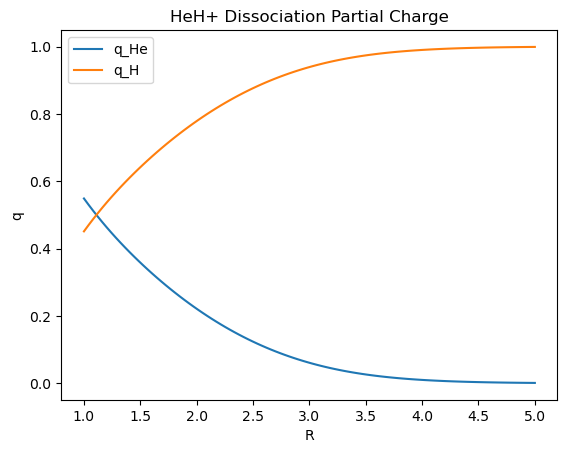

In [47]:
# plt.rcParams['text.usetex'] = True

fig, ax = plt.subplots()
ax.plot(Rs, q_Hes, label='q_He')
ax.plot(Rs, q_Hs, label='q_H')
ax.set_title('HeH+ Dissociation Partial Charge')
ax.set_xlabel('R')
ax.set_ylabel('q')
ax.legend()
plt.savefig('Visualizations/2_iii.png')

# Question 3

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

N_nuc = 3 # number of atoms
L = 2 # number of basis functions per contracted basis function
K = 7 # number of contracted basis functions

OH_bond_length = 1.809
HOH_angle = 104.52 * np.pi/180 # numpy's sine and cosine functions expect angles in radians

# widths of the basis functions
zeta_H = 1.24
zeta_O = 7.66

# basis set coefficients
one_s_coeff_1 =  0.164964
one_s_coeff_2 =  0.381381
two_s_coeff_1 =  0.168105
two_s_coeff_2 =  0.0241442
two_p_coeff_1 =  1.0
two_p_coeff_2 = -1.0

# part of the gaussian widths for each basis function
one_s_width_1 = 0.151623
one_s_width_2 = 0.851819
two_s_width_1 = 0.493363
two_s_width_2 = 1.945230
two_p_width_1 = 0.9

# offset in the exponent for the p orbital functions
two_p_offset_1 =  0.1
two_p_offset_2 = -0.1

# place holders
R_nuclei = np.zeros((N_nuc, 3))
widths = np.zeros((L, K))
contraction_coeffs = np.zeros((L, K))
centers = np.zeros((L, K, 3))

# fill in our water coordinates. Oxygen is in the center, the hydrogen atoms are in the x-y plane below the oxygenatom
R_nuclei[0, :] = [0, 0, 0]
R_nuclei[1, :] = [ OH_bond_length*np.sin(HOH_angle/2), -OH_bond_length*np.cos(HOH_angle/2), 0]
R_nuclei[2, :] = [-OH_bond_length*np.sin(HOH_angle/2), -OH_bond_length*np.cos(HOH_angle/2), 0]

# the orbitals are ordered 1s_H, 1s_H, 1s_O, 2s_O, 2p_O, 2p_O, 2p_O
# widths of the contracted basis function components
widths[:, 0] = [one_s_width_1*zeta_H**2, one_s_width_2*zeta_H**2]
widths[:, 1] = [one_s_width_1*zeta_H**2, one_s_width_2*zeta_H**2]
widths[:, 2] = [one_s_width_1*zeta_O**2, one_s_width_2*zeta_O**2]
widths[:, 3] = [two_s_width_1, two_s_width_2]
widths[:, 4] = [two_p_width_1, two_p_width_1]
widths[:, 5] = [two_p_width_1, two_p_width_1]
widths[:, 6] = [two_p_width_1, two_p_width_1]

# coefficients for each contracted basis set component
contraction_coeffs[:, 0] = [one_s_coeff_1, one_s_coeff_2]
contraction_coeffs[:, 1] = [one_s_coeff_1, one_s_coeff_2]
contraction_coeffs[:, 2] = [one_s_coeff_1, one_s_coeff_2]
contraction_coeffs[:, 3] = [two_s_coeff_1, two_s_coeff_2]
contraction_coeffs[:, 4] = [two_p_coeff_1, two_p_coeff_2]
contraction_coeffs[:, 5] = [two_p_coeff_1, two_p_coeff_2]
contraction_coeffs[:, 6] = [two_p_coeff_1, two_p_coeff_2]

# for the centers keep in mind that the offset in the p-orbitals depends on which p orbital we are looking at
# centers in the x direction
centers[:, 0, 0] = [R_nuclei[1, 0], R_nuclei[1, 0]]
centers[:, 1, 0] = [R_nuclei[2, 0], R_nuclei[2, 0]]
centers[:, 2, 0] = [R_nuclei[0, 0], R_nuclei[0, 0]]
centers[:, 3, 0] = [R_nuclei[0, 0], R_nuclei[0, 0]]
centers[:, 4, 0] = [R_nuclei[0, 0] + two_p_offset_1, R_nuclei[0, 0] + two_p_offset_2]
centers[:, 5, 0] = [R_nuclei[0, 0], R_nuclei[0, 0]]
centers[:, 6, 0] = [R_nuclei[0, 0], R_nuclei[0, 0]]

# centers in the y direction
centers[:, 0, 1] = [R_nuclei[1, 1], R_nuclei[1, 1]]
centers[:, 1, 1] = [R_nuclei[2, 1], R_nuclei[2, 1]]
centers[:, 2, 1] = [R_nuclei[0, 1], R_nuclei[0, 1]]
centers[:, 3, 1] = [R_nuclei[0, 1], R_nuclei[0, 1]]
centers[:, 4, 1] = [R_nuclei[0, 1], R_nuclei[0, 1]]
centers[:, 5, 1] = [R_nuclei[0, 1] + two_p_offset_1, R_nuclei[0, 1] + two_p_offset_2]
centers[:, 6, 1] = [R_nuclei[0, 1], R_nuclei[0, 1]]

# centers in the z direction
centers[:, 0, 2] = [R_nuclei[1, 2], R_nuclei[1, 2]]
centers[:, 1, 2] = [R_nuclei[2, 2], R_nuclei[2, 2]]
centers[:, 2, 2] = [R_nuclei[0, 2], R_nuclei[0, 2]]
centers[:, 3, 2] = [R_nuclei[0, 2], R_nuclei[0, 2]]
centers[:, 4, 2] = [R_nuclei[0, 2], R_nuclei[0, 2]]
centers[:, 5, 2] = [R_nuclei[0, 2], R_nuclei[0, 2]]
centers[:, 6, 2] = [R_nuclei[0, 2] + two_p_offset_1, R_nuclei[0, 2] + two_p_offset_2]


